# 05 Predicting Behaviour with Microbiome Data

This notebook shows attempts at predicting the behavioural development and sleep quality score with microbiome data.
We will use microbiome composition and predicited functional potential to predict the behavioural measures.

This notebook can be executed on a SLURM cluster, when submitting the job from the `scripts/` directory:
```bash
sbatch --time=03:59:00 --cpus-per-task=8 --mem-per-cpu=5G --output=slurm-%j.out --error=slurm-%j.err --wrap="bash -c 'module load eth_proxy && source $HOME/.bashrc && conda activate microbEvolve && jupyter nbconvert --to notebook --execute ./05-2_prediction.ipynb --output ./05-2_prediction.ipynb'"
```

In [1]:
import time
import warnings
import os

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from qiime2 import Artifact
import scipy.stats as stats

data_dir = "../data"

plt.style.use("../presentation.mplstyle")
os.makedirs("../figures", exist_ok=True)

# Check if Source Sans Pro is available, only needed for presentation.mplstyle
fonts = [f.name for f in fm.fontManager.ttflist]
if "Source Sans Pro" not in fonts:
    plt.rcParams['font.family'] = 'sans-serif'
    print("Source Sans Pro not found, using default sans-serif font.")

%matplotlib inline

In [2]:
import sklearn

sklearn.set_config(enable_metadata_routing=True)

from sklearn.pipeline import Pipeline
from sklearn.metrics import PredictionErrorDisplay, r2_score, root_mean_squared_error
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    cross_val_predict,
    cross_validate,
    GroupKFold,
)
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor

from skbio.stats.composition import clr
from skbio.stats.composition import multi_replace

In [3]:
try:
    num_cpus = int(os.environ["SLURM_CPUS_PER_TASK"])
except KeyError:
    num_cpus = os.cpu_count()

In [4]:
# This is a helper function to store the model performance metric in a markdown file

def save_performance_metrics(cv_results, model_name, file_path):
    """
    Saves the performance metrics of a model to a markdown file.
    """
    # Ensure the directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    with open(file_path, "a") as f:
        f.write(f"## {model_name}\n\n")
        
        # Time metrics
        if 'fit_time' in cv_results:
            f.write(f"- **Mean Fit Time:** {cv_results['fit_time'].mean():.4f}s ± {cv_results['fit_time'].std():.4f}s\n")
        if 'score_time' in cv_results:
            f.write(f"- **Mean Score Time:** {cv_results['score_time'].mean():.4f}s ± {cv_results['score_time'].std():.4f}s\n")
        f.write("\n")

        # Score metrics
        # Identify metrics based on keys starting with 'test_'
        metrics = [key.replace('test_', '') for key in cv_results.keys() if key.startswith('test_')]
        
        for metric in metrics:
            test_key = f"test_{metric}"
            train_key = f"train_{metric}"
            
            test_scores = cv_results[test_key]
            
            # Flip sign for error metrics that are negative
            if metric in ['rmse', 'mae', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']:
                 display_test_scores = -test_scores
            else:
                 display_test_scores = test_scores
            
            f.write(f"### Metric: {metric.upper()}\n")
            f.write(f"- **Test Mean ± Std:** {display_test_scores.mean():.4f} ± {display_test_scores.std(ddof=1):.4f}\n")
            
            if train_key in cv_results:
                train_scores = cv_results[train_key]
                if metric in ['rmse', 'mae', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']:
                    display_train_scores = -train_scores
                else:
                    display_train_scores = train_scores
                f.write(f"- **Train Mean ± Std:** {display_train_scores.mean():.4f} ± {display_train_scores.std(ddof=1):.4f}\n")
            
            f.write("\n**Per-Fold Test Scores:**\n")
            for i, score in enumerate(display_test_scores):
                f.write(f"- Fold {i+1}: {score:.4f}\n")
            f.write("\n")

        f.write("### Best Parameters per Fold\n")
        if 'estimator' in cv_results:
            for i, estimator in enumerate(cv_results['estimator']):
                if hasattr(estimator, 'best_params_'):
                    f.write(f"- **Fold {i+1}:** {estimator.best_params_}\n")
                else:
                    f.write(f"- **Fold {i+1}:** Parameters not available\n")
        f.write("\n---\n\n")
    
    print(f"Performance metrics for '{model_name}' saved to {file_path}")

## Behavioural Development

Before diving into the notebook, I want to comment on the behavioural development score.

The behavioral development score is based on the "Ages and Stages questionnaire". Information about it can be found in this [presentation](https://agesandstages.com/wp-content/uploads/2018/02/interpretingresults_slidepresentation_020818.pdf) and the original [paper](https://www.researchgate.net/publication/14006008_Revision_of_a_Parent-Completed_Developmental_Screening_Tool_Ages_and_Stages_Questionnaires). This questionnaire is used by doctors to assess the development of infants in different areas. 
The five categories that are assesed are:
- Communication
- Gross Motor
- Fine Motor
- Problem Solving
- Personal-Social

The parents of the infants fill out different questions for each category in the form. Based on the answers a score for each category is awarded. If the score of a category falls below a specified cut off, the infant is thought to show delayed development in this category.
The cutoff is defined to be two standard deviations below the mean ($\mu - 2 \cdot \sigma$) of a representative sample.

This already shows the problem with the behavioral development score that we have in the metadata. Our score seems to indicate the total points awarded to an infant over all five categories. As developmental delay is determined for each category individually, a total score does not have much clinical relevance. This is illustrated nicely by an example:
- Imagine infant 1  scores perfectly in four of the five categories. In the last category it falls slightly below the cutoff, which indicates delay in e.g. fine motor development.
- Infant 2 barely passes the cutoff value in all five categories, indicating no developmental delay.

Infant 1 will definitely receive a higher total score than Infant 2. This misses the developmental delay of Infant 1 and implies the developmental delay of Infant 2, which is not the case. Scores that fall below the cutoff in one category can be compensated by high scores in other categories. This makes it extremely difficult to assess whether an infant might show developmental delays simply based on a total score. In clinical practice, each category is looked at in an isolated way, and developmental status is assessed independently of the other categories. Therefore, the total score does not provide us with the needed information and misinterprets the "Ages and Stages questionnaire".

This is the reason we stick with the continous variable and do not transform the problem to a classification task, which might yield better results. 
There is no information published about a potential cutoff value of the total ASQ score for such a binerization, as this does not reflect clinical pratice. 
Using the $\mu - 2 \cdot \sigma$ approach also does not make sense, as this will most likely underestimate the number of delayed infants. 

In [5]:
# Calculate the percentage of values below μ - 2σ
mu, sigma = 0, 1
cutoff = mu - 2*sigma

percentage_below = stats.norm.cdf(cutoff, mu, sigma) * 100

print(f"Percentage of values below μ - 2$\\sigma$: {percentage_below:.4f}%")

Percentage of values below μ - 2$\sigma$: 2.2750%


Based on the Table 5 in [Squires et al.](https://www.researchgate.net/publication/14006008_Revision_of_a_Parent-Completed_Developmental_Screening_Tool_Ages_and_Stages_Questionnaires), roughly 13 % ($209/1511 \approx 0.138$) of infants show developmental delays, compared to the 2.28 % detected when using the total score.

We will go ahead anyway and try to get some information out of the microbiome composition. 
We will simply keep this discrepancy between our measure and the clinical reality in mind when assessing performance of our models.

In [6]:
development_results_file_path = f"{data_dir}/results/model_performance_development.md"

# Create the results file and any missing directories
os.makedirs(os.path.dirname(development_results_file_path), exist_ok=True)
with open(development_results_file_path, "w") as f:
    f.write("# Predicting Behavioural Development: Model Performance\n\n")

In [7]:
metadata = pd.read_csv(f"{data_dir}/raw/metadata.tsv", index_col=0, header=0, sep="\t")
metadata.head()

,infant_id,timepoint,sample_number,age_days,sex,feeding_method,birth_mode,collection_date,collection_site,behavioral_development,parent_attuned_caring_style,sleep_rhythmicity,sleep_quality
sampleid,,,,,,,,,,,,,
sample_1,1,2 months,1,69,Male,primarily breast-fed at enrolment,vaginal birth,2023,pediatrician x,300.0,3.307692,0.601667,0.477522
sample_2,1,2 months,2,69,Male,primarily breast-fed at enrolment,vaginal birth,2023,pediatrician x,300.0,3.307692,0.601667,0.477522
sample_3,1,2 months,3,69,Male,primarily breast-fed at enrolment,vaginal birth,2023,pediatrician x,300.0,3.307692,0.601667,0.477522
sample_4,1,2 months,4,70,Male,primarily breast-fed at enrolment,vaginal birth,2023,pediatrician x,300.0,3.307692,0.601667,0.477522
sample_5,1,2 months,5,71,Male,primarily breast-fed at enrolment,vaginal birth,2023,pediatrician x,300.0,3.307692,0.601667,0.477522


In [8]:
feature_table = Artifact.load(f"{data_dir}/raw/dada2_table.qza").view(pd.DataFrame)
features = feature_table.columns

In [9]:
data = pd.merge(left=metadata, right=feature_table, left_index=True, right_index=True)

print(f"Original dataset size: {len(data)} samples")
model_data = data.dropna(subset=["behavioral_development"])
print(
    f"Dataset size after removing missing behavioral development values: {len(model_data)} samples"
)
print(f"Number of samples lost: {len(data) - len(model_data)} samples")

Original dataset size: 130 samples
Dataset size after removing missing behavioral development values: 103 samples
Number of samples lost: 27 samples


In [10]:
y = model_data.behavioral_development
X = model_data[features]

### Naive Approach

In the naive approach, we ignore the grouping structure of the data (multiple samples per infant) and perform simple nested cross-validation.
This allows us to generate predictions for every sample in our data.
In the pipeline we apply a center-log transformation to the abundance data, as this is recommended by [Gloor et al.](https://doi.org/10.3389/fmicb.2017.02224) and [Quinn et al.](https://doi.org/10.1093/gigascience/giz107) when working with compositional count data.
We also scale the features which helps ML models by ensuring all features are on the same scale. This is also needed when interpreting feature importance, which we will not do in this notebook.
As the first model we train a simple Lasso regression. This is compuationally inexpensive and could be a good entry-point to get a feel for the data.


In [11]:
cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
cv_outer = KFold(n_splits=5, shuffle=True, random_state=2)

param_grid = {"lasso__alpha": np.logspace(-3, 1, num=10)}
best_params = {"lasso__alpha": []}

pipe = Pipeline(
    steps=[
        ("replace", FunctionTransformer(multi_replace)),
        ("clr", FunctionTransformer(clr, validate=False)),
        ("var", VarianceThreshold(1e-6)),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lasso", Lasso(max_iter=10000)),
    ]
)

model = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_inner,
    scoring="neg_root_mean_squared_error",
    n_jobs=num_cpus,
    error_score="raise",
    verbose=True,
)

# Nested CV with access to per-fold best params
scoring_metrics = {"rmse": "neg_root_mean_squared_error", "mae": "neg_mean_absolute_error", "r2": "r2"}
cv_results = cross_validate(
    estimator=model,
    X=X,
    y=y,
    cv=cv_outer,
    scoring=scoring_metrics,
    n_jobs=num_cpus,
    return_estimator=True,
    return_train_score=True,
    verbose=1,
)

y_pred = cross_val_predict(model, X=X, y=y, cv=cv_outer, n_jobs=num_cpus, verbose=True)

# pause for two seconds to let all threads finish printing their output
time.sleep(2)
print("\n*** Nested CV Results (Naive Approach) ***")
rmse_per_fold = -cv_results["test_rmse"]
r2_per_fold = cv_results["test_r2"]
print("Outer-CV RMSE mean ± sd:", rmse_per_fold.mean(), "±", rmse_per_fold.std(ddof=1))
print("Outer-CV R2 mean ± sd:", r2_per_fold.mean(), "±", r2_per_fold.std(ddof=1))
best_alphas = [est.best_params_["lasso__alpha"] for est in cv_results["estimator"]]
print("Best alpha per outer fold:", best_alphas)

save_performance_metrics(cv_results, "Naive Approach (Nested CV)", development_results_file_path)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.5s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s


[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    2.2s finished



*** Nested CV Results (Naive Approach) ***
Outer-CV RMSE mean ± sd: 16.49373787305958 ± 4.503943733854912
Outer-CV R2 mean ± sd: 0.4632118847172312 ± 0.5222306085379756
Best alpha per outer fold: [3.5938136638046254, 0.05994842503189409, 0.00774263682681127, 0.001, 1.2915496650148826]
Performance metrics for 'Naive Approach (Nested CV)' saved to ../data/results/model_performance_development.md


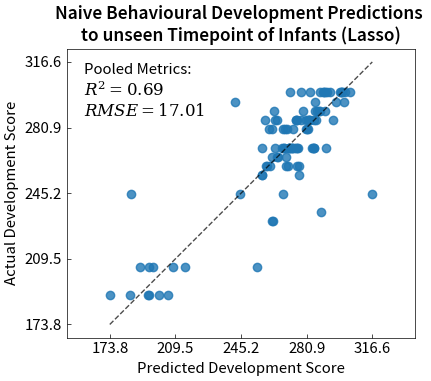

In [12]:
pooled_r_2 = r2_score(y, y_pred)
pooled_rmse = root_mean_squared_error(y, y_pred)

fig, ax = plt.subplots(figsize=(4.5, 3.75))
ax.set_aspect('equal', 'box')
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    random_state=0,
)
ax.annotate(f"Pooled Metrics: \n$R^2 = {pooled_r_2:.2f}$\n$RMSE = {pooled_rmse:.2f}$",
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=12
            )

ax.set_ylabel("Actual Development Score")
ax.set_xlabel("Predicted Development Score")
ax.set_title("Naive Behavioural Development Predictions \nto unseen Timepoint of Infants (Lasso)")
fig.savefig("../figures/pred_behaviour_naive_lasso.pdf")
fig.show()

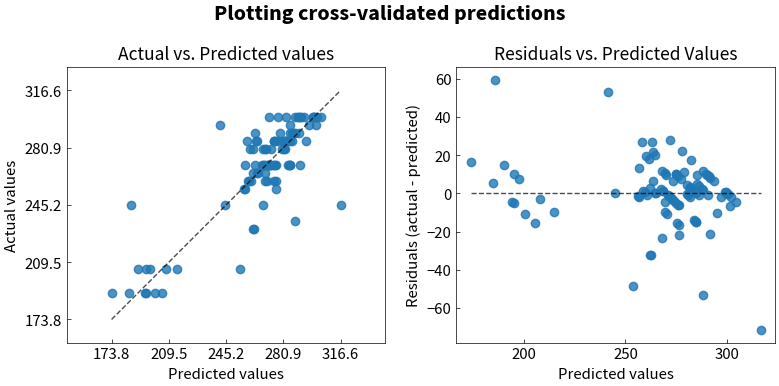

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values", fontweight="normal")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1],
)
axs[1].set_title("Residuals vs. Predicted Values", fontweight="normal")
fig.suptitle("Plotting cross-validated predictions", fontweight="bold")
fig.tight_layout()
# fig.savefig("../figures/pred_behaviour_naive.pdf")
fig.show()

The performance seems to really good. Overall, we are able to predict the true development score very well. This makes me sceptical, as I am not confident in claiming that microbiome compoisiton and behavioural development show such a strong relationship. Based on our previous results, we can assume that we need to be concerned with data leakage during training at this point.

### Generalzation to unseen infants

In this approach, we take into account the grouping structure of the data and perform cross-validation such that all samples from a given infant are either in the training or test set.
This gives a more realistic estimate of model performance on unseen infants.

In [14]:
model_data.infant_id.nunique()

17

In [15]:
groups = model_data["infant_id"]

# cv_inner = LeavePGroupsOut(n_groups=3)
# cv_outer = LeavePGroupsOut(n_groups=3)

cv_inner = GroupKFold(n_splits=10)
cv_outer = GroupKFold(n_splits=10)

param_grid = {"lasso__alpha": np.logspace(-3, 1, num=10)}
best_params = {"lasso__alpha": []}

pipe = Pipeline(
    steps=[
        ("replace", FunctionTransformer(multi_replace)),
        ("clr", FunctionTransformer(clr, validate=False)),
        ("var", VarianceThreshold(1e-6)),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lasso", Lasso(max_iter=10000)),
    ]
)

model_loo = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_inner,
    scoring="neg_root_mean_squared_error",
    n_jobs=num_cpus,
    error_score="raise",
    verbose=True,
)

# Nested CV with access to per-fold best params
scoring_metrics = {"rmse": "neg_root_mean_squared_error", "mae": "neg_mean_absolute_error", "r2": "r2"}
cv_results = cross_validate(
    estimator=model_loo,
    X=X,
    y=y,
    params = {'groups': groups},
    cv=cv_outer,
    scoring=scoring_metrics,
    n_jobs=num_cpus,
    return_estimator=True,
    return_train_score=True,
    verbose=1,
    error_score="raise",
)

y_pred = cross_val_predict(
    model_loo, X=X, y=y, params = {'groups': groups}, cv=cv_outer, n_jobs=num_cpus, verbose=True
)

# pause for two seconds to let all threads finish printing their output
time.sleep(2)
print("\n*** Generalize to unseen infants: Group K-Fold (Lasso) ***")
rmse_per_fold = -cv_results["test_rmse"]
print("Outer-CV RMSE mean ± sd:", rmse_per_fold.mean(), "±", rmse_per_fold.std(ddof=1))
print("Outer-CV R2 mean ± sd:", r2_per_fold.mean(), "±", r2_per_fold.std(ddof=1))
best_alphas = [est.best_params_["lasso__alpha"] for est in cv_results["estimator"]]
print("Best alpha per outer fold:", best_alphas)

save_performance_metrics(cv_results, "Generalize to unseen infants: Group K-Fold (Lasso)", development_results_file_path)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    4.7s remaining:    3.1s


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    5.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    4.6s remaining:    3.1s


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    5.8s finished



*** Generalize to unseen infants: Group K-Fold (Lasso) ***
Outer-CV RMSE mean ± sd: 29.264412966546438 ± 22.631781614928784
Outer-CV R2 mean ± sd: 0.4632118847172312 ± 0.5222306085379756
Best alpha per outer fold: [1.2915496650148826, 3.5938136638046254, 0.4641588833612777, 3.5938136638046254, 1.2915496650148826, 3.5938136638046254, 0.00774263682681127, 1.2915496650148826, 0.4641588833612777, 0.4641588833612777]
Performance metrics for 'Generalize to unseen infants: Group K-Fold (Lasso)' saved to ../data/results/model_performance_development.md


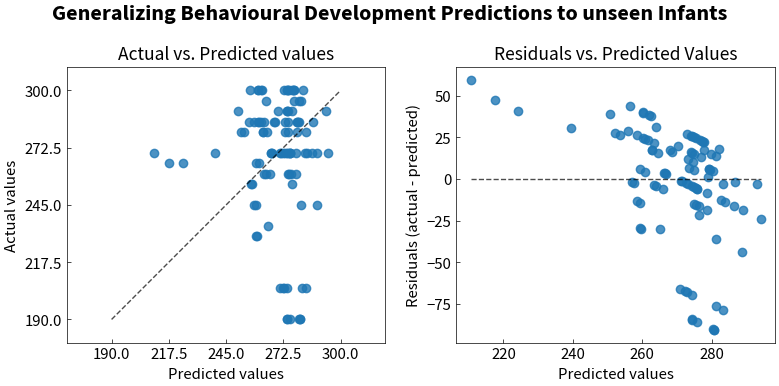

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values", fontweight="normal")

PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1],
)

axs[1].set_title("Residuals vs. Predicted Values", fontweight="normal")
fig.suptitle("Generalizing Behavioural Development Predictions to unseen Infants", fontweight="bold")

fig.tight_layout()
# fig.savefig("../figures/pred_behaviour_generalize_strict.pdf")
fig.show()

We see a huge drop in performance in this case. This is most likely due to the too optimistic prediction due to data leakage in the previous case.
As most samples from one each infant clustered together quite tightly (see `adonis` results), they share a similar microbiome composition. In the previous example, the model was able to pick up on the similarity between these samples. As samples from the same infant at one timepoint also have the same behavioural development score, the prediction is quite easy.

We have restricted this by placing samples from the same infant only in either the test or training set. This means that data leakage due to similar samples from the same infant does not happen. We might argue that this is too strict. The model is not allowed to learn from previous timepoints of an infant, as we strictly group by `infant_id`. 

### Generalize to unseen timepoint of infant

We can now group the cross-validation splits by a combination of `infant_id` and `timepoint`. Only samples from the same infant at one timepoint are required to be placed in either the train or test set, but not both. This approach is identical to using the collapsed feature table seen in previous notebooks but has the advantage to incorporate intra-infant-timepoint variability. This might make the model more robust.

In [17]:
groups = model_data["infant_id"].astype(str) + model_data["timepoint"].astype(str)

cv_inner = GroupKFold(n_splits=10)
cv_outer = GroupKFold(n_splits=10)

param_grid = {"lasso__alpha": np.logspace(-3, 1, num=10)}
best_params = {"lasso__alpha": []}

pipe = Pipeline(
    steps=[
        ("replace", FunctionTransformer(multi_replace)),
        ("clr", FunctionTransformer(clr, validate=False)),
        ("var", VarianceThreshold(1e-6)),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lasso", Lasso(max_iter=10000)),
    ]
)

model_loo = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_inner,
    scoring="neg_root_mean_squared_error",
    n_jobs=num_cpus,
    error_score="raise",
    verbose=True,
)

# Nested CV with access to per-fold best params
scoring_metrics = {"rmse": "neg_root_mean_squared_error", "mae": "neg_mean_absolute_error", "r2": "r2"}
cv_results = cross_validate(
    estimator=model_loo,
    X=X,
    y=y,
    params = {'groups': groups},
    cv=cv_outer,
    scoring=scoring_metrics,
    n_jobs=num_cpus,
    return_estimator=True,
    return_train_score=True,
    verbose=1,
    error_score="raise",
)

y_pred = cross_val_predict(
    model_loo, X=X, y=y, params = {'groups': groups}, cv=cv_outer, n_jobs=num_cpus, verbose=True
)

# pause for two seconds to let all threads finish printing their output
time.sleep(2)
print("\n*** Generalize to unseen timepoint of infant: Group K-Fold (Lasso) ***")
rmse_per_fold = -cv_results["test_rmse"]
print("Outer-CV RMSE mean ± sd:", rmse_per_fold.mean(), "±", rmse_per_fold.std(ddof=1))
print("Outer-CV R2 mean ± sd:", r2_per_fold.mean(), "±", r2_per_fold.std(ddof=1))
best_alphas = [est.best_params_["lasso__alpha"] for est in cv_results["estimator"]]
print("Best alpha per outer fold:", best_alphas)

save_performance_metrics(cv_results, "Generalize to unseen timepoint of infants: Group K-Fold (Lasso)", development_results_file_path)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    4.2s remaining:    2.8s


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    5.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    4.2s remaining:    2.8s


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    5.3s finished



*** Generalize to unseen timepoint of infant: Group K-Fold (Lasso) ***
Outer-CV RMSE mean ± sd: 24.505048022383438 ± 16.888008824435687
Outer-CV R2 mean ± sd: 0.4632118847172312 ± 0.5222306085379756
Best alpha per outer fold: [3.5938136638046254, 1.2915496650148826, 1.2915496650148826, 1.2915496650148826, 1.2915496650148826, 0.4641588833612777, 3.5938136638046254, 0.001, 1.2915496650148826, 1.2915496650148826]
Performance metrics for 'Generalize to unseen timepoint of infants: Group K-Fold (Lasso)' saved to ../data/results/model_performance_development.md


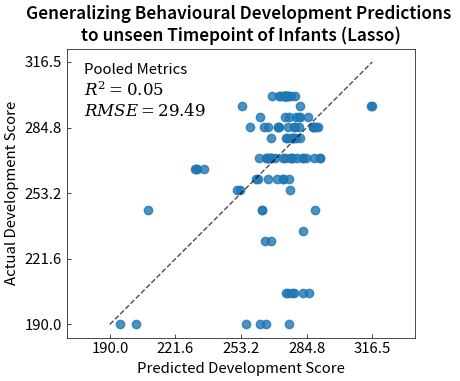

In [18]:
pooled_r_2 = r2_score(y, y_pred)
pooled_rmse = root_mean_squared_error(y, y_pred)

fig, ax = plt.subplots(figsize=(4.5, 3.75))
ax.set_aspect('equal', 'box')
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    random_state=0,
)
ax.annotate(f"Pooled Metrics\n$R^2 = {pooled_r_2:.2f}$\n$RMSE = {pooled_rmse:.2f}$",
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=12
            )

ax.set_ylabel("Actual Development Score")
ax.set_xlabel("Predicted Development Score")
ax.set_title("Generalizing Behavioural Development Predictions \nto unseen Timepoint of Infants (Lasso)")
fig.savefig("../figures/pred_behaviour_generalize_lasso.pdf")
fig.show()

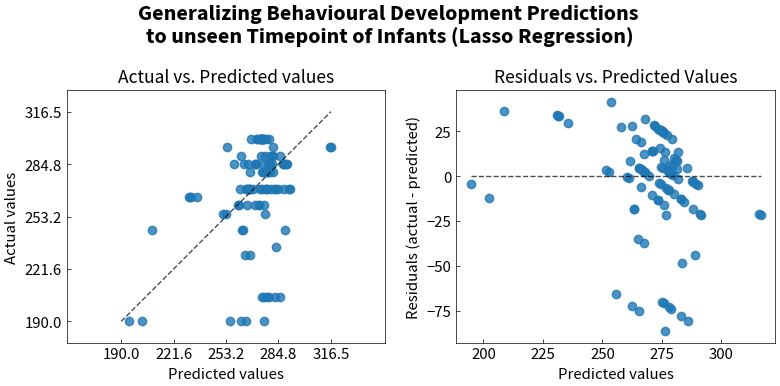

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values", fontweight="normal")

PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1],
)

axs[1].set_title("Residuals vs. Predicted Values", fontweight="normal")
fig.suptitle("Generalizing Behavioural Development Predictions \nto unseen Timepoint of Infants (Lasso Regression)", fontweight="bold")

fig.tight_layout()
# fig.savefig("../figures/pred_behaviour_generalize_timepoint.pdf")
fig.show()

Sadly this does not improve performance significantly, but I have a last hope: more complexity.

We can try to train a more complex model, which might be able to extract more information from the data. Microbiome composition data is probably not immediately linked to behaviour development, but might have a more abstract relationship with it. A more complex model could potentially pick up on this. As a last resort, we will try a regressor based on XGBoost. 

In [20]:
groups = model_data["infant_id"].astype(str) + model_data["timepoint"].astype(str)

# cv_inner = LeavePGroupsOut(n_groups=3)
# cv_outer = LeavePGroupsOut(n_groups=3)

cv_inner = GroupKFold(n_splits=10)
cv_outer = GroupKFold(n_splits=10)

param_grid = {"gradient_boosting__max_depth": np.linspace(3, 20, num=10, dtype=int),
            #   "pca__n_components": np.linspace(5, 50, num=10, dtype=int)
              }
best_params = {
    "gradient_boosting__max_depth": [],
    # "pca__n_components": []
}

pipe = Pipeline(
    steps=[
        ("replace", FunctionTransformer(multi_replace)),
        ("clr", FunctionTransformer(clr, validate=False)),
        # ("pca", PCA()),
        ("var", VarianceThreshold(1e-6)),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("gradient_boosting", GradientBoostingRegressor(n_estimators=1000)),
    ]
)

model_gbr = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_inner,
    scoring="neg_root_mean_squared_error",
    n_jobs=num_cpus,
    error_score="raise",
    verbose=True,
)

# Nested CV with access to per-fold best params
scoring_metrics = {"rmse": "neg_root_mean_squared_error", "mae": "neg_mean_absolute_error", "r2": "r2"}
cv_results = cross_validate(
    estimator=model_gbr,
    X=X,
    y=y,
    params = {'groups': groups},
    cv=cv_outer,
    scoring=scoring_metrics,
    n_jobs=num_cpus,
    return_estimator=True,
    return_train_score=True,
    verbose=1,
    error_score="raise",
)

y_pred = cross_val_predict(
    model_gbr, X=X, y=y, params = {'groups': groups}, cv=cv_outer, n_jobs=num_cpus, verbose=True
)

# pause for two seconds to let all threads finish printing their output
time.sleep(2)
print("\n*** Generalize to unseen timepoint of infants: Group K-Fold (Gradient Boosting) ***")

rmse_per_fold = -cv_results["test_rmse"]
print(f"Outer-CV RMSE mean ± sd: {rmse_per_fold.mean():.2f} ± {rmse_per_fold.std(ddof=1):.2f}")
r2_per_fold = cv_results["test_r2"]
print("Outer-CV R2 mean ± sd:", r2_per_fold.mean(), "±", r2_per_fold.std(ddof=1))

best_depth = [est.best_params_["gradient_boosting__max_depth"] for est in cv_results["estimator"]]
print("Best tree max depth per outer fold:", best_depth)

# best_n_components = [est.best_params_["pca__n_components"] for est in cv_results["estimator"]]
# print("Best n_components per outer fold:", best_n_components)

save_performance_metrics(cv_results, "Generalize to unseen timepoint of infants: Group K-Fold (Gradient Boosting)", development_results_file_path)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:  5.9min remaining:  4.0min


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  7.5min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:  6.2min remaining:  4.1min


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  7.8min finished



*** Generalize to unseen timepoint of infants: Group K-Fold (Gradient Boosting) ***
Outer-CV RMSE mean ± sd: 29.02 ± 15.52
Outer-CV R2 mean ± sd: -2.37865102216145 ± 3.8107315568016333
Best tree max depth per outer fold: [3, 3, 3, 3, 3, 3, 3, 3, 8, 6]
Performance metrics for 'Generalize to unseen timepoint of infants: Group K-Fold (Gradient Boosting)' saved to ../data/results/model_performance_development.md


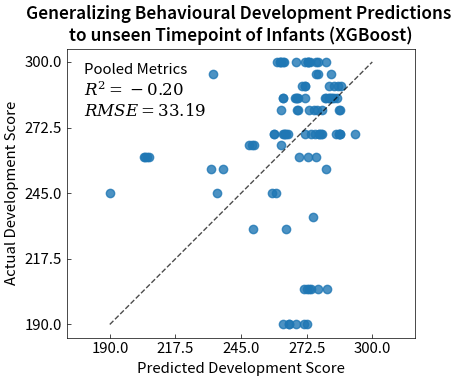

In [ ]:
pooled_r_2 = r2_score(y, y_pred)
pooled_rmse = root_mean_squared_error(y, y_pred)

fig, ax = plt.subplots(figsize=(4.5, 3.75))
ax.set_aspect('equal', 'box')
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    random_state=0,
)
ax.annotate(f"Pooled Metrics\n$R^2 = {pooled_r_2:.2f}$\n$RMSE = {pooled_rmse:.2f}$",
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=12
            )

ax.set_ylabel("Actual Development Score")
ax.set_xlabel("Predicted Development Score")
ax.set_title("Generalizing Behavioural Development Predictions \nto unseen Timepoint of Infants (XGBoost)")
fig.savefig("../figures/pred_behaviour_generalize_xgboost.pdf")
fig.show()

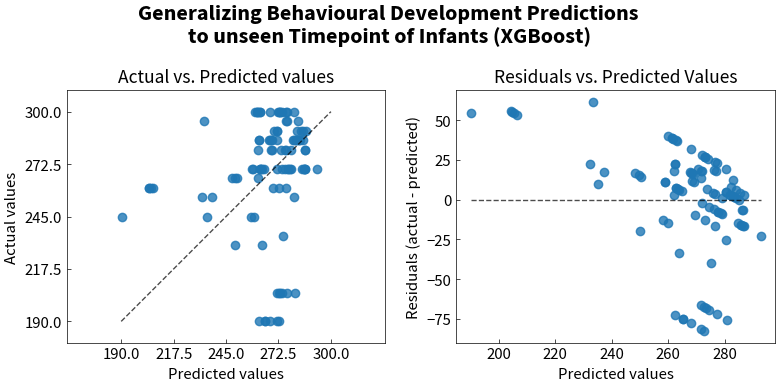

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values", fontweight="normal" )
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1],
)
axs[1].set_title("Residuals vs. Predicted Values", fontweight="normal")
fig.suptitle("Generalizing Behavioural Development Predictions \nto unseen Timepoint of Infants (XGBoost)", fontweight="bold")
plt.tight_layout()
plt.show()

TODO: Add description of performance here. 

I have also played around with different dimensionality approaches, e.g. PCA, but none have added siginificant benefits to the model performance. 

## Sleep Quality

We will turn to the sleep quality measure now, which is not inherently flawed as the "behavioural development" score is. We will try the similar approaches again and expand to using the predicted functional potential as model input.

In [23]:
sleep_results_file_path = f"{data_dir}/results/model_performance_sleep_quality.md"

# Create the results file and any missing directories
os.makedirs(os.path.dirname(sleep_results_file_path), exist_ok=True)
with open(sleep_results_file_path, "w") as f:
    f.write("# Predicting Sleep Quality: Model Performance\n\n")

In [24]:
print(f"Original dataset size: {len(data)} samples")
sleep_model_data = data.dropna(subset=["sleep_quality"])
print(
    f"Dataset size after removing missing sleep quality values: {len(sleep_model_data)} samples"
)
print(f"Number of samples lost: {len(data) - len(sleep_model_data)} samples")

y = sleep_model_data.sleep_quality
X = sleep_model_data[features]

Original dataset size: 130 samples
Dataset size after removing missing sleep quality values: 103 samples
Number of samples lost: 27 samples


In [25]:
groups = model_data["infant_id"].astype(str) + model_data["timepoint"].astype(str)

cv_inner = GroupKFold(n_splits=7)
cv_outer = GroupKFold(n_splits=7)

param_grid = {"lasso__alpha": np.logspace(-3, 1, num=10)}
best_params = {"lasso__alpha": []}

pipe = Pipeline(
    steps=[
        ("replace", FunctionTransformer(multi_replace)),
        ("clr", FunctionTransformer(clr, validate=False)),
        ("var", VarianceThreshold(1e-6)),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lasso", Lasso(max_iter=10000)),
    ]
)

model_loo = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_inner,
    scoring="neg_root_mean_squared_error",
    n_jobs=num_cpus,
    error_score="raise",
    verbose=True,
)

# Nested CV with access to per-fold best params
scoring_metrics = {"rmse": "neg_root_mean_squared_error", "mae": "neg_mean_absolute_error", "r2": "r2"}
cv_results = cross_validate(
    estimator=model_loo,
    X=X,
    y=y,
    params = {'groups': groups},
    cv=cv_outer,
    scoring=scoring_metrics,
    n_jobs=num_cpus,
    return_estimator=True,
    return_train_score=True,
    verbose=1,
    error_score="raise",
)

y_pred = cross_val_predict(
    model_loo, X=X, y=y, params = {'groups': groups}, cv=cv_outer, n_jobs=num_cpus, verbose=True
)

# pause for two seconds to let all threads finish printing their output
time.sleep(2)
print("\n*** Generalize to unseen timepoint of infant: Group K-Fold (Lasso) ***")
rmse_per_fold = -cv_results["test_rmse"]
print("Outer-CV RMSE mean ± sd:", rmse_per_fold.mean(), "±", rmse_per_fold.std(ddof=1))
print("Outer-CV R2 mean ± sd:", r2_per_fold.mean(), "±", r2_per_fold.std(ddof=1))
best_alphas = [est.best_params_["lasso__alpha"] for est in cv_results["estimator"]]
print("Best alpha per outer fold:", best_alphas)

save_performance_metrics(cv_results, "Generalize to unseen timepoint of infants: Group K-Fold (Lasso)", sleep_results_file_path)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:    0.8s finished



*** Generalize to unseen timepoint of infant: Group K-Fold (Lasso) ***
Outer-CV RMSE mean ± sd: 0.11638025753225377 ± 0.02331993421107792
Outer-CV R2 mean ± sd: -2.37865102216145 ± 3.8107315568016333
Best alpha per outer fold: [0.00774263682681127, 0.021544346900318832, 0.021544346900318832, 0.002782559402207126, 0.00774263682681127, 0.021544346900318832, 0.021544346900318832]
Performance metrics for 'Generalize to unseen timepoint of infants: Group K-Fold (Lasso)' saved to ../data/results/model_performance_sleep_quality.md


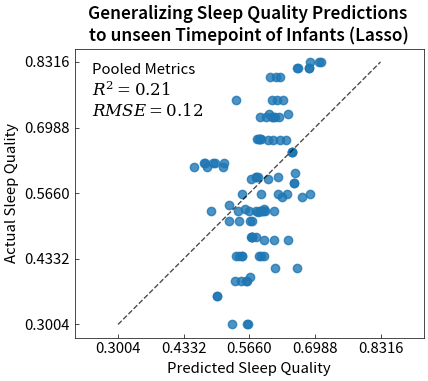

In [26]:
pooled_r_2 = r2_score(y, y_pred)
pooled_rmse = root_mean_squared_error(y, y_pred)

fig, ax = plt.subplots(figsize=(4.5, 3.75))
ax.set_aspect('equal', 'box')
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    random_state=0,
)
ax.annotate(f"Pooled Metrics\n$R^2 = {pooled_r_2:.2f}$\n$RMSE = {pooled_rmse:.2f}$",
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=12
            )

ax.set_ylabel("Actual Sleep Quality")
ax.set_xlabel("Predicted Sleep Quality")
ax.set_title("Generalizing Sleep Quality Predictions \nto unseen Timepoint of Infants (Lasso)")
fig.savefig("../figures/pred_sleep_microbiome_lasso.pdf")
fig.show()

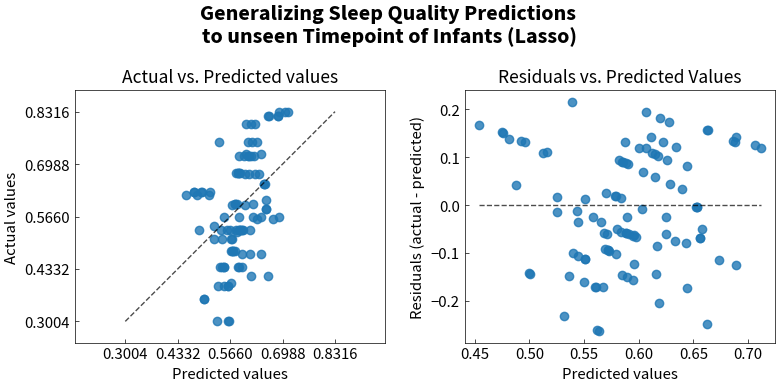

In [27]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values", fontweight="normal")

PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1],
)
axs[1].set_title("Residuals vs. Predicted Values", fontweight="normal")
fig.suptitle("Generalizing Sleep Quality Predictions \nto unseen Timepoint of Infants (Lasso)", fontweight="bold")
fig.tight_layout()
# fig.savefig("../figures/pred_sleep_microbiome_lasso.pdf")
fig.show()

The performance here reminds us of previous problems...
TODO: expand description

### Functional Abundance as Input

As we have predicted the funtional potential of the gut microbiome using PICRUSt2, we could use these feature tables as input. Maybe the functional potential of the gut microbiome contains some information about sleep quality? In constrast to raw count data, this is not as abstracted from the biological impact the microbiome composition might have on sleep. We can hope that the models might be able to learn any underlying information. We could imagine food digestion or similar factors impacting sleep quality, which might be reflected in the functional annotation. 

On the other hand we need to keep in mind that this data is predicted by PICRUSt2. There is no guarantee, that the predicted functional potential reflects the ground truth. With this approach, we add a layer of uncertainty to the process. 

In [28]:
metadata = pd.read_csv(f"{data_dir}/raw/metadata.tsv", sep="\t", header=0, index_col=0)
pathway_table = Artifact.load(f"{data_dir}/processed/picrust2_results/pathway_abundance.qza").view(pd.DataFrame)
pathways = pathway_table.columns

pathway_data = pd.merge(left=metadata, right=pathway_table, left_index=True, right_index=True)

print(f"Original dataset size: {len(pathway_data)} samples")
pathway_sleep_model_data = pathway_data.dropna(subset=["sleep_quality"])
print(
    f"Dataset size after removing missing sleep quality values: {len(pathway_sleep_model_data)} samples"
)
print(f"Number of samples lost: {len(pathway_data) - len(pathway_sleep_model_data)} samples")

y = pathway_sleep_model_data.sleep_quality
X = pathway_sleep_model_data[pathways]

Original dataset size: 130 samples
Dataset size after removing missing sleep quality values: 103 samples
Number of samples lost: 27 samples


In [29]:
groups = model_data["infant_id"].astype(str) + model_data["timepoint"].astype(str)

cv_inner = GroupKFold(n_splits=7)
cv_outer = GroupKFold(n_splits=7)

param_grid = {"lasso__alpha": np.logspace(-3, 1, num=10)}
best_params = {"lasso__alpha": []}

pipe = Pipeline(
    steps=[
        ("replace", FunctionTransformer(multi_replace)),
        ("clr", FunctionTransformer(clr, validate=False)),
        ("var", VarianceThreshold(1e-6)),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lasso", Lasso(max_iter=10000)),
    ]
)

model_loo = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_inner,
    scoring="neg_root_mean_squared_error",
    n_jobs=num_cpus,
    error_score="raise",
    verbose=True,
)

# Nested CV with access to per-fold best params
scoring_metrics = {"rmse": "neg_root_mean_squared_error", "mae": "neg_mean_absolute_error", "r2": "r2"}
cv_results = cross_validate(
    estimator=model_loo,
    X=X,
    y=y,
    params = {'groups': groups},
    cv=cv_outer,
    scoring=scoring_metrics,
    n_jobs=num_cpus,
    return_estimator=True,
    return_train_score=True,
    verbose=1,
    error_score="raise",
)

y_pred = cross_val_predict(
    model_loo, X=X, y=y, params = {'groups': groups}, cv=cv_outer, n_jobs=num_cpus, verbose=True
)

# pause for two seconds to let all threads finish printing their output
time.sleep(2)
print("\n*** Pathway data - Generalize to unseen timepoint of infant: Group K-Fold (Lasso) ***")
rmse_per_fold = -cv_results["test_rmse"]
print("Outer-CV RMSE mean ± sd:", rmse_per_fold.mean(), "±", rmse_per_fold.std(ddof=1))
r2_per_fold = cv_results["test_r2"]
print("Outer-CV R2 mean ± sd:", r2_per_fold.mean(), "±", r2_per_fold.std(ddof=1))
best_alphas = [est.best_params_["lasso__alpha"] for est in cv_results["estimator"]]
print("Best alpha per outer fold:", best_alphas)

save_performance_metrics(cv_results, "Pathway data - Generalize to unseen timepoint of infant: Group K-Fold (Lasso)", sleep_results_file_path)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:    0.7s finished



*** Pathway data - Generalize to unseen timepoint of infant: Group K-Fold (Lasso) ***
Outer-CV RMSE mean ± sd: 0.1243815419685408 ± 0.03325703916540659
Outer-CV R2 mean ± sd: -1.7598241502301235 ± 3.080530130826395
Best alpha per outer fold: [0.00774263682681127, 0.021544346900318832, 0.021544346900318832, 0.021544346900318832, 0.00774263682681127, 0.021544346900318832, 0.021544346900318832]
Performance metrics for 'Pathway data - Generalize to unseen timepoint of infant: Group K-Fold (Lasso)' saved to ../data/results/model_performance_sleep_quality.md


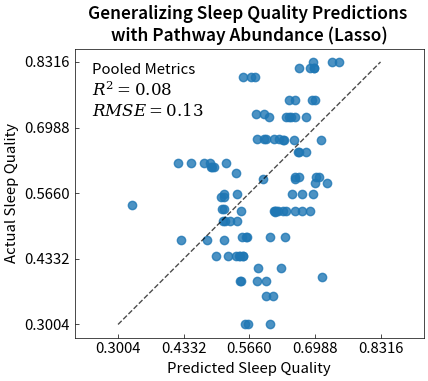

In [30]:
pooled_r_2 = r2_score(y, y_pred)
pooled_rmse = root_mean_squared_error(y, y_pred)

fig, ax = plt.subplots(figsize=(4.5, 3.75))
ax.set_aspect('equal', 'box')
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    random_state=0,
)
ax.annotate(f"Pooled Metrics\n$R^2 = {pooled_r_2:.2f}$\n$RMSE = {pooled_rmse:.2f}$",
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=12
            )

ax.set_ylabel("Actual Sleep Quality")
ax.set_xlabel("Predicted Sleep Quality")
ax.set_title("Generalizing Sleep Quality Predictions \nwith Pathway Abundance (Lasso)")
fig.savefig("../figures/pred_sleep_pathway_lasso.pdf")
fig.show()

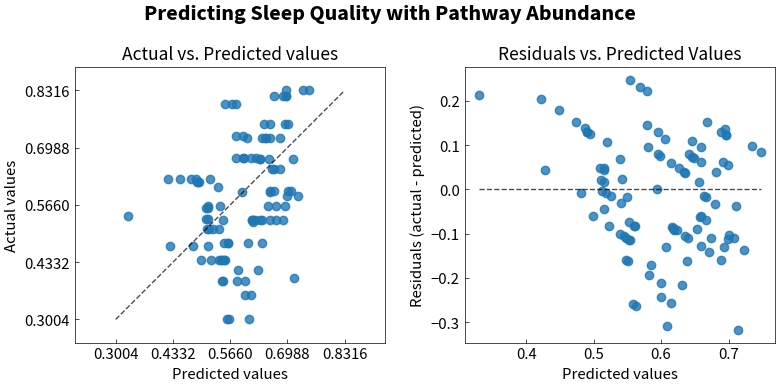

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values", fontweight="normal")

PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1],
)
axs[1].set_title("Residuals vs. Predicted Values", fontweight="normal")
fig.suptitle("Predicting Sleep Quality with Pathway Abundance", fontweight="bold")
fig.tight_layout()
# fig.savefig("../figures/pred_sleep_pathway_lasso.pdf")
fig.show()

This seems to improve the performance slightly. Test $RMSE$ and $R^2$ have gone down compared to the previous attempt with composition data. 

Let's try with the Gradient Boosted Regressor again. We could gain some performace due to the enhanced complexity.

In [32]:
groups = model_data["infant_id"].astype(str) + model_data["timepoint"].astype(str)

cv_inner = GroupKFold(n_splits=7)
cv_outer = GroupKFold(n_splits=7)

param_grid = {
    "gradient_boosting__max_depth": np.linspace(3, 20, num=10, dtype=int)
}
best_params = {
    "gradient_boosting__max_depth": [],
}

pipe = Pipeline(
    steps=[
        ("replace", FunctionTransformer(multi_replace)),
        ("clr", FunctionTransformer(clr, validate=False)),
        ("var", VarianceThreshold(1e-6)),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("gradient_boosting", GradientBoostingRegressor(n_estimators=1000)),
    ]
)

model_gbr = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_inner,
    scoring="neg_root_mean_squared_error",
    n_jobs=num_cpus,
    error_score="raise",
    verbose=True,
)

# Nested CV with access to per-fold best params
scoring_metrics = {"rmse": "neg_root_mean_squared_error", "mae": "neg_mean_absolute_error", "r2": "r2"}
cv_results = cross_validate(
    estimator=model_gbr,
    X=X,
    y=y,
    params = {'groups': groups},
    cv=cv_outer,
    scoring=scoring_metrics,
    n_jobs=num_cpus,
    return_estimator=True,
    return_train_score=True,
    verbose=1,
    error_score="raise",
)

y_pred = cross_val_predict(
    model_gbr, X=X, y=y, params = {'groups': groups}, cv=cv_outer, n_jobs=num_cpus, verbose=True
)

# pause for two seconds to let all threads finish printing their output
time.sleep(2)
print("\n*** Pathway data - Generalize to unseen timepoint of infant: Group K-Fold (Gradient Boosting) ***")

rmse_per_fold = -cv_results["test_rmse"]
print(f"Outer-CV RMSE mean ± sd: {rmse_per_fold.mean():.2f} ± {rmse_per_fold.std(ddof=1):.2f}")
r2_per_fold = cv_results["test_r2"]
print("Outer-CV R2 mean ± sd:", r2_per_fold.mean(), "±", r2_per_fold.std(ddof=1))

best_depth = [est.best_params_["gradient_boosting__max_depth"] for est in cv_results["estimator"]]
print("Best tree max depth per outer fold:", best_depth)


save_performance_metrics(cv_results, "Pathway data - Generalize to unseen timepoint of infant: Group K-Fold (Gradient Boosting)", sleep_results_file_path)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:  1.7min finished



*** Pathway data - Generalize to unseen timepoint of infant: Group K-Fold (Gradient Boosting) ***
Outer-CV RMSE mean ± sd: 0.15 ± 0.04
Outer-CV R2 mean ± sd: -2.875652422698606 ± 4.903697480471594
Best tree max depth per outer fold: [3, 4, 3, 3, 3, 3, 3]
Performance metrics for 'Pathway data - Generalize to unseen timepoint of infant: Group K-Fold (Gradient Boosting)' saved to ../data/results/model_performance_sleep_quality.md


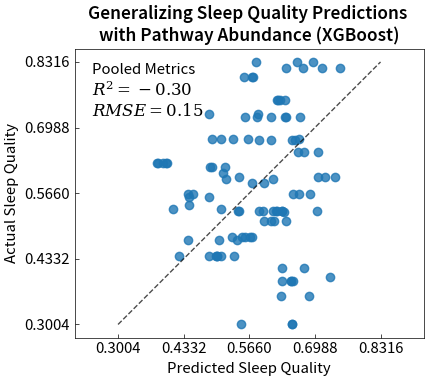

In [33]:
pooled_r_2 = r2_score(y, y_pred)
pooled_rmse = root_mean_squared_error(y, y_pred)

fig, ax = plt.subplots(figsize=(4.5, 3.75))
ax.set_aspect('equal', 'box')
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    random_state=0,
)
ax.annotate(f"Pooled Metrics\n$R^2 = {pooled_r_2:.2f}$\n$RMSE = {pooled_rmse:.2f}$",
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=12
            )

ax.set_ylabel("Actual Sleep Quality")
ax.set_xlabel("Predicted Sleep Quality")
ax.set_title("Generalizing Sleep Quality Predictions \nwith Pathway Abundance (XGBoost)")
fig.savefig("../figures/pred_sleep_pathway_xgboost.pdf")
fig.show()

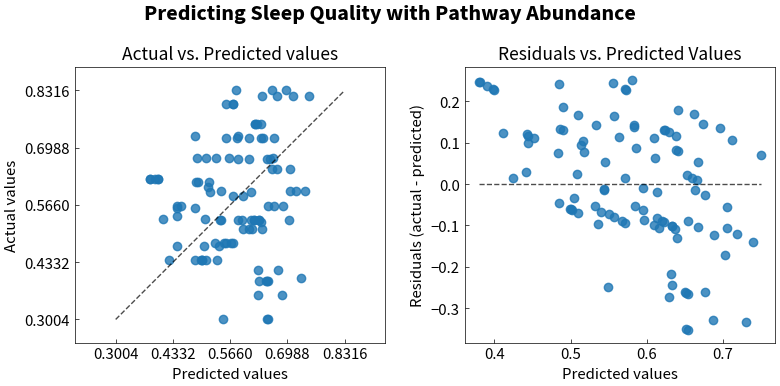

In [34]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values", fontweight="normal")

PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1],
)
axs[1].set_title("Residuals vs. Predicted Values", fontweight="normal")
fig.suptitle("Predicting Sleep Quality with Pathway Abundance", fontweight="bold")
fig.tight_layout()
# fig.savefig("../figures/pred_sleep_pathway_xgboost.pdf")
fig.show()